In [1]:
import numpy as np
import sys
sys.path.append('../')
import random
import torch
from pathlib import Path
import matplotlib.pyplot as plt
from generators.math_utils_torch import *
from generators.volumetric_rendering import create_cam2world_matrix
import math
import open3d as o3d
import cv2 as cv
import OpenEXR

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Produce wrong camera matrix

In [4]:
cameras = np.load('/usr/stud/zhouzh/data/ShapeNetCar/baa1e44e6e086c233e320a6703976361/cameras.npz')
cam_false={}
def clip_norm(x, lower=0.7, upper=1.5):
    """clip the norm of input tensor x to the range of [lower, upper]"""
    x=torch.from_numpy(x)
    denom = x.norm(dim=0, keepdim=True)
    denom_clip = torch.clamp(denom, lower, upper)
    return (x / denom * denom_clip).numpy()
for i in range(24):
    cam = cameras[f'world_mat_inv_{i}']
    cam_origin = cam[:3, -1]
    cam_origin[random.randint(0,2)]*=-1
    cam_origin+=np.random.randn(3)*0.1
    cam_origin = clip_norm(cam_origin)
    cam[:3,-1]=cam_origin
    cam_false[f'world_mat_inv_{i}']=cam
np.savez('/usr/stud/zhouzh/data/ShapeNetCar/baa1e44e6e086c233e320a6703976361/cameras_false.npz', **cam_false)


# Project the GT dataset

In [9]:
K

array([[2.1875, 0.    , 0.    ],
       [0.    , 2.1875, 0.    ],
       [0.    , 0.    , 1.    ]])

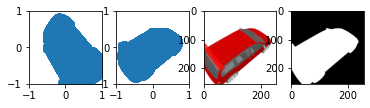

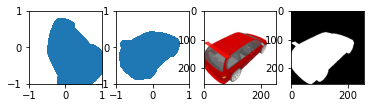

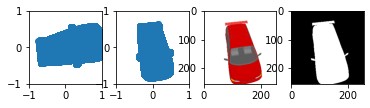

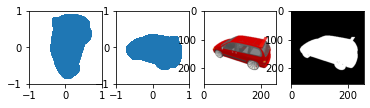

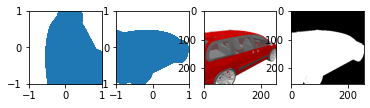

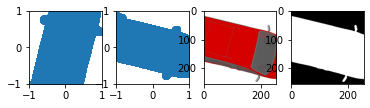

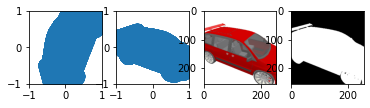

KeyboardInterrupt: 

In [47]:
dir = Path('../../data/ShapeNetCar/baa1e44e6e086c233e320a6703976361/')
cameras = np.load(dir/'cameras.npz')
points = np.load(dir/'pointcloud.npz')
pcl = points['points']
scale = points['scale']
for id in range(24):
    # id = 0
    extrinsics = cameras[f'world_mat_{id}']
    # extrinsics = extrinsics.numpy()
    K = cameras[f'camera_mat_{0}'][:3,:3]
    # K = np.eye(3)
    R = extrinsics[:3,:3]
    t = extrinsics[:3,-1:]
    
    fig = plt.figure()
    ax = fig.add_subplot(141)
    pcl_c = (R @ pcl.T) + t
    pcl_cam = K @ pcl_c / (K @ pcl_c)[-1]
    img = pcl_cam.T[:,:-1]
    ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
    plt.scatter(img[:,1], img[:,0])
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)

    ax = fig.add_subplot(142)
    pcl_c = (R @ (pcl*scale).T) + t
    pcl_cam = K @ pcl_c / (K @ pcl_c)[-1]
    img = pcl_cam.T[:,:-1]
    ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
    plt.scatter(img[:,0], -img[:,1])
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)

    ax2=fig.add_subplot(143)
    img = plt.imread(dir/'image'/f'{id:04}.png')
    ax2.imshow(img)

    ax2=fig.add_subplot(144)
    img = plt.imread(dir/'mask'/f'{id:04}.png')
    ax2.imshow(img)
    plt.show()

In [5]:
def read_depth_rgb(id) -> np.ndarray:
    """Read depth map from the .exr file

    Args:
        fpath (str): the path to the .exr depth map

    Returns:
        np.ndarray: 256*256, depth map
    """
    # car_dir = "/usr/stud/zhouzh/data/ShapeNetCar/baa1e44e6e086c233e320a6703976361/"
    car_dir = "/usr/stud/zhouzh/stanford-shapenet-renderer/test/baa1e44e6e086c233e320a6703976361"
    fpath = str(Path(car_dir) / "depth" / f"{id:04}0001.exr")
    readFile = OpenEXR.InputFile(fpath)
    (r, g, b) = readFile.channels("RGB")
    dr = np.copy(np.frombuffer(r, dtype=np.half))
    db = np.copy(np.frombuffer(b, dtype=np.half))
    dg = np.copy(np.frombuffer(g, dtype=np.half))
    assert np.allclose(dr, db)
    assert np.allclose(db, dg)
    h = (
        readFile.header()["displayWindow"].max.y
        + 1
        - readFile.header()["displayWindow"].min.y
    )
    w = (
        readFile.header()["displayWindow"].max.x
        + 1
        - readFile.header()["displayWindow"].min.x
    )
    depth = np.reshape(dr, (h, w)).astype(np.float64)
    depth[depth == 65504] = np.inf
    depth[depth == np.inf] = 0
    rgb_path = Path(car_dir) / "image" / f"{id:04}.png"
    rgb = cv.imread(str(rgb_path), cv.IMREAD_UNCHANGED)
    rgb = cv.cvtColor(rgb, cv.COLOR_BGR2RGB)
    rgb = (rgb / 256).astype("uint8") / 256
    assert rgb.shape[0] == depth.shape[0]
    assert rgb.shape[1] == depth.shape[1]
    assert rgb.shape[2] == 3
    return depth, rgb

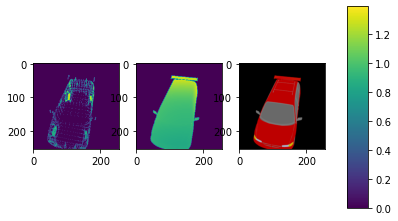

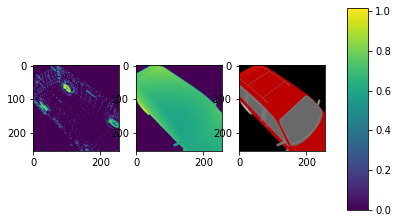

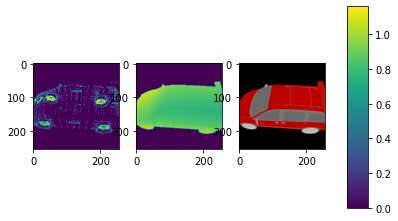

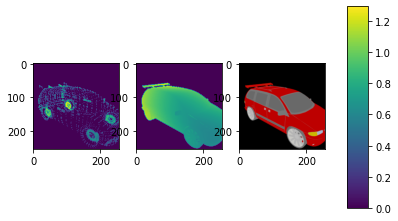

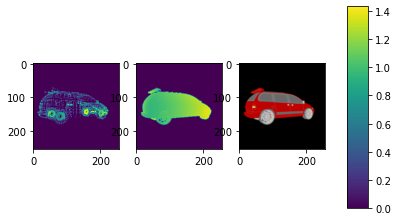

KeyError: 'world_mat_5 is not a file in the archive'

In [6]:
# dir = Path("../../data/ShapeNetCar/baa1e44e6e086c233e320a6703976361/")
dir = Path('/usr/stud/zhouzh/stanford-shapenet-renderer/test/baa1e44e6e086c233e320a6703976361')
cameras = np.load(dir / "cameras.npz")
points = np.load(dir / "pointcloud.npz")
pcl = points["points"]
scale = points["scale"]
for id in range(5):
    extrinsics = cameras[f"world_mat_{id}"]
    # extrinsics = extrinsics.numpy()
    K = cameras[f"camera_mat_{0}"][:3, :3]
    # K = np.eye(3)
    R = extrinsics[:3, :3]
    t = extrinsics[:3, -1:]

    pcl_c = ((R @ pcl.T) + t).T
    # pcl_cam = K @ pcl_c / (K @ pcl_c)[-1]
    # img = pcl_cam.T[:,:-1]
    # img[:,1]*=-1
    z = pcl_c[:, -1]
    x = pcl_c[:, 0]
    y = pcl_c[:, 1]
    u = x * 2.1875 / z
    v = y * 2.1875 / z
    H = 256
    W = 256
    i = ((H - 1) * u + (H - 1)) / 2
    j = ((W - 1) * v + (W - 1)) / 2
    pcl_projected = np.zeros((256, 256))
    for m in range(i.shape[0]):
        if 0 <= i[m] <= 255 and 0 <= j[m] <= 255:
            pcl_projected[int(j[m]), int(i[m])] = z[m]

    depth, rgb = read_depth_rgb(id)
    fig, axes = plt.subplots(nrows=1, ncols=3)
    im1 = axes[0].imshow(pcl_projected)
    im2 = axes[1].imshow(depth)
    axes[2].imshow(rgb)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im2, cax=cbar_ax)
    plt.show()

# Verify camera origin

In [124]:
for i in range(24):
    camera_origin = (
        torch.from_numpy(cameras[f"world_mat_inv_{i}"][:3, -1])
        .type(torch.float32)
        .unsqueeze(0)
    )
    forward_vector = normalize_vecs(-camera_origin)
    cam2world_matrix = create_cam2world_matrix(
        forward_vector, camera_origin, device=torch.device("cpu")
    )[0]
    cam2world_matrix = cam2world_matrix.numpy()
    cam2world_gt = cameras[f"world_mat_inv_{i}"].astype('float32')
    print(cam2world_gt)
    print(cam2world_matrix)
    print('\n')


[[ 7.5065607e-01 -5.2370822e-01  4.0279660e-01 -4.2305818e-01]
 [ 7.5140720e-09 -6.0965765e-01 -7.9266477e-01  8.3253759e-01]
 [ 6.6069311e-01  5.9501874e-01 -4.5764318e-01  4.8066366e-01]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]
[[ 0.75065607  0.5237082  -0.40279666 -0.42305818]
 [ 0.          0.60965765  0.7926648   0.8325376 ]
 [ 0.66069317 -0.5950187   0.4576432   0.48066366]
 [ 0.          0.          0.          1.        ]]


[[ 6.6012394e-01 -4.5414647e-01  5.9832042e-01 -6.6607624e-01]
 [ 2.6422560e-09 -7.9653215e-01 -6.0459614e-01  6.7306256e-01]
 [ 7.5115669e-01  3.9910841e-01 -5.2580994e-01  5.8535433e-01]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]
[[ 0.66012394  0.45414647 -0.5983205  -0.66607624]
 [ 0.          0.7965322   0.60459614  0.67306256]
 [ 0.75115675 -0.39910838  0.52580994  0.5853543 ]
 [ 0.          0.          0.          1.        ]]


[[ 1.7816058e-01  7.6434970e-01 -6.1970025e-01  7.4653465e-01]
 [-6.4138708e-09 

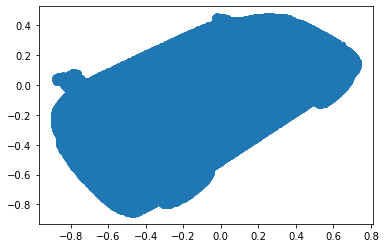

In [21]:
dir = Path('../data/ShapeNetCar/baa1e44e6e086c233e320a6703976361/')
cameras = np.load(dir/'cameras.npz')
points = np.load(dir/'pointcloud.npz')
pcl = points['points']
scale = points['scale']
id=0
extrinsics = cameras[f'world_mat_{id}']
# extrinsics = extrinsics.numpy()
K = cameras[f'camera_mat_{0}'][:3,:3]
R = extrinsics[:3,:3]
t = extrinsics[:3,-1:]
pcl_c = (R @ (pcl*scale).T) + t
pcl_cam = K @ pcl_c / (K @ pcl_c)[-1]
img = pcl_cam.T[:,:-1]
plt.scatter(img[:,0], -img[:,1])
plt.show()

In [25]:
K

array([[2.1875, 0.    , 0.    , 0.    ],
       [0.    , 2.1875, 0.    , 0.    ],
       [0.    , 0.    , 1.    , 0.    ],
       [0.    , 0.    , 0.    , 1.    ]])

In [35]:
for cam_d in dir.parent.iterdir():
    if cam_d.is_dir():
        cam=np.load(cam_d/'cameras.npz')
        for i in range(24):
            k2=cam[f'camera_mat_{i}']
            assert np.all(K==k2), print(cam_d)

In [ ]:
import math
def get_initial_rays_trig(n, num_steps, device, fov, resolution, ray_start, ray_end):
    """Returns sample points, z_vals, and ray directions in camera space."""

    W, H = resolution
    # Create full screen NDC (-1 to +1) coords [x, y, 0, 1].
    # Y is flipped to follow image memory layouts.
    x, y = torch.meshgrid(
        torch.linspace(-1, 1, W, device=device), torch.linspace(1, -1, H, device=device)
    )
    x = x.T.flatten()
    y = y.T.flatten()
    z = -torch.ones_like(x, device=device) / np.tan((2 * math.pi * fov / 360) / 2) # -1/tan(fov/2)

    rays_d_cam = normalize_vecs(torch.stack([x, y, z], -1))  # ray directions

    z_vals = (
        torch.linspace(ray_start, ray_end, num_steps, device=device)
        .reshape(1, num_steps, 1)
        .repeat(W * H, 1, 1)
    )
    points = rays_d_cam.unsqueeze(1).repeat(1, num_steps, 1) * z_vals  # t*d

    points = torch.stack(n * [points])
    z_vals = torch.stack(n * [z_vals])
    rays_d_cam = torch.stack(n * [rays_d_cam]).to(device)
    return points, z_vals, rays_d_cam

In [42]:
W, H = (128,128)
fov = 30
# Create full screen NDC (-1 to +1) coords [x, y, 0, 1].
# Y is flipped to follow image memory layouts.
x, y = torch.meshgrid(
    torch.linspace(-1, 1, W), torch.linspace(1, -1, H)
)
x = x.T.flatten()
y = y.T.flatten()
z = -torch.ones_like(x) / np.tan((2 * math.pi * fov / 360) / 2) # -1/tan(fov/2)
rays_d_cam = normalize_vecs(torch.stack([x, y, z], -1))  # ray directions

print(rays_d_cam)

tensor([[-0.2506,  0.2506, -0.9351],
        [-0.2469,  0.2508, -0.9360],
        [-0.2431,  0.2511, -0.9369],
        ...,
        [ 0.2431, -0.2511, -0.9369],
        [ 0.2469, -0.2508, -0.9360],
        [ 0.2506, -0.2506, -0.9351]])


In [43]:
W, H = (128,128)
fov = 45
# Create full screen NDC (-1 to +1) coords [x, y, 0, 1].
# Y is flipped to follow image memory layouts.
x, y = torch.meshgrid(
    torch.linspace(-1, 1, W), torch.linspace(1, -1, H)
)
x = x.T.flatten()
y = y.T.flatten()
z = -torch.ones_like(x) / np.tan((2 * math.pi * fov / 360) / 2) # -1/tan(fov/2)
rays_d_cam = normalize_vecs(torch.stack([x, y, z], -1))  # ray directions
print(rays_d_cam)

tensor([[-0.3574,  0.3574, -0.8629],
        [-0.3525,  0.3581, -0.8646],
        [-0.3475,  0.3588, -0.8663],
        ...,
        [ 0.3475, -0.3588, -0.8663],
        [ 0.3525, -0.3581, -0.8646],
        [ 0.3574, -0.3574, -0.8629]])


# check depth map and transformed points

In [142]:
dir = Path('/usr/stud/zhouzh/data/ShapeNetCar/baa1e44e6e086c233e320a6703976361/image/0009.png')

cams = np.load(dir.parent.parent / 'cameras.npz')
cam2world_gt = cams[f'world_mat_inv_{int(dir.stem)}']
# cam2world_gt[:,1]*=-1
# cam2world_gt[:,2]*=-1
print(cam2world_gt)

depth=torch.load('depths')[0]
rgb=torch.load('rgb')[0].permute(1,2,0)
cam2world=torch.load('cam2world').detach().cpu().numpy()[0]
print(cam2world)

points=torch.load('points').detach().cpu().numpy()[0]
print(points.shape)
depth_pts=[]
color_pts =[]
H,W = depth.shape
for x in range(H):
    for y in range(W):
        if depth[x,y]!=0:
            xx = (2*x-H)/H
            yy = -(2*y-W)/W
            depth_pts.append([xx,yy,-depth[x,y].item()])
            color_pts.append(rgb[x,y].numpy())
depth_pts = np.array(depth_pts)
depth_pts_homo = np.ones((depth_pts.shape[0],4))
depth_pts_homo[:,:3]=depth_pts
depths_pts_w = (cam2world @ depth_pts_homo.T).T[:,:3]
color_pts = np.asarray(color_pts)
points = points.reshape(-1,3)

[[-6.97121489e-01 -3.03285676e-01  6.49645626e-01 -9.42598149e-01]
 [-2.82371120e-08 -9.06120058e-01 -4.23020348e-01  6.13778006e-01]
 [ 7.16953042e-01 -2.94896545e-01  6.31675797e-01 -9.16524969e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[-0.6973  0.3032 -0.6494 -0.9424]
 [ 0.      0.9062  0.423   0.614 ]
 [ 0.717   0.295  -0.632  -0.9165]
 [ 0.      0.      0.      1.    ]]
(16384, 16, 3)


In [141]:
points.shape

(262144, 3)

In [113]:
neg = o3d.geometry.PointCloud()
neg.points = o3d.utility.Vector3dVector(depths_pts_w)
neg.paint_uniform_color([0, 0.706, 1])


pos = o3d.geometry.PointCloud()
pos.points = o3d.utility.Vector3dVector(points)
pos.paint_uniform_color([1, 0.706, 0])

o3d.visualization.draw_geometries([neg, pos], width=1800, height=950)

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


In [ ]:
def visualize_sampled_negative_points(pcl_path, radius, num_pos_points, neg_to_pos_ratio):
    pcl = np.load(pcl_path)["points"]
    pcl = torch.from_numpy(pcl)
    pcl = pcl.type(torch.float32)
    pcl_ds = pcl[torch.randperm(100000)[:num_pos_points]]
    # Y = pdist(pcl_ds, 'euclidean')
    # print(Y.shape)
    # print(Y.min().item(), Y.max().item())

    start = time.time()
    tree = KDTree(pcl_ds)
    neg = torch.rand(int(num_pos_points * neg_to_pos_ratio), 3) - 0.5
    results = tree.query_ball_point(neg, radius)
    ids = [idx for idx, i in enumerate(results) if not i]
    real_neg = neg[ids]
    end = time.time()
    
    print(f"KDTree query time: {round(end - start, 5)}s")
    print("neg ratio: ", len(ids) / (num_pos_points * neg_to_pos_ratio), " | neg num: ", len(ids), "| pos num: ", num_pos_points)
    print(
        f"The average number of pos neighbors within {radius} ball per point:",
        len(tree.query_pairs(r=radius)) * 2 / num_pos_points,
    )

    real_neg = real_neg[torch.where(real_neg[:, 0] > -0.3)]
    real_neg = real_neg[torch.where(real_neg[:, 0] < 0.3)]

    neg = o3d.geometry.PointCloud()
    neg.points = o3d.utility.Vector3dVector(real_neg)
    # neg.paint_uniform_color([1, 0.706, 0])
    neg.colors = o3d.utility.Vector3dVector(real_neg + 0.5)

    pos = o3d.geometry.PointCloud()
    pos.points = o3d.utility.Vector3dVector(pcl_ds)
    pos.paint_uniform_color([1, 0.706, 0])

    o3d.visualization.draw_geometries([neg, pos], width=1800, height=950)


In [11]:
dir = Path('/usr/stud/zhouzh/data/ShapeNetCar/baa1e44e6e086c233e320a6703976361/image/0009.png')

cams = np.load(dir.parent.parent / 'cameras.npz')
cam2world_gt = cams[f'world_mat_inv_{int(dir.stem)}']

In [12]:

cams[f'camera_mat_inv_0']

array([[0.45714286, 0.        , 0.        , 0.        ],
       [0.        , 0.45714286, 0.        , 0.        ],
       [0.        , 0.        , 1.        , 0.        ],
       [0.        , 0.        , 0.        , 1.        ]])